[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aymgal/herculens_workspace/blob/dev/notebooks/herculens__Complex_source_with_wavelets.ipynb)

# Modeling a complex source with wavelets

__author__: @aymgal

__last updated__: 17/08/22

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Installing requirements and dependencies
    !pip install --quiet git+https://github.com/austinpeel/herculens.git@dev-aym
    !pip install --quiet blackjax==0.9.6 numpyro==0.10.1 emcee==3.0.2
    !pip install --quiet jaxns dynesty getdist

In [1]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm, Normalize, TwoSlopeNorm
plt.rc('image', interpolation='none')

# Basic imports
import os
from time import time
import numpy as np
from astropy.io import fits
from copy import deepcopy
from pprint import pprint
%matplotlib inline


# Herculens imports
from herculens.Coordinates.pixel_grid import PixelGrid
from herculens.Instrument.psf import PSF
from herculens.Instrument.noise import Noise
from herculens.LightModel.light_model import LightModel
from herculens.MassModel.mass_model import MassModel
from herculens.LensImage.lens_image import LensImage
from herculens.Parameters.parameters import Parameters
from herculens.Inference.loss import Loss
from herculens.Inference.optimization import Optimizer
from herculens.Analysis.plot import Plotter
from herculens.Util import image_util, param_util, plot_util

# Baseline font soze
FS = 18

# Plotting engine
plotter = Plotter(base_fontsize=FS, flux_vmin=1e-3, flux_vmax=1e0, res_vmax=6)

## 1. Simulate an observation of a lensed source

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [2]:
npix = 80  # number of pixel on a side
pix_scl = 0.08  # pixel size in arcsec
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2  # position of the (0, 0) with respect to bottom left pixel
transform_pix2angle = pix_scl * np.eye(2)  # transformation matrix pixel <-> angle
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}

# create the PixelGrid class
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates
extent = pixel_grid.extent

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (80, 80) pixels
pixel size : 0.08 arcsec
x range    : (-3.16, 3.16) arcsec
y range    : (-3.16, 3.16) arcsec


### Point spread function (PSF)

For simplicity we assume here a Gaussian PSF.

In [3]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.15}
psf = PSF(**kwargs_psf)

### Noise

In [4]:
# exposure time, used for estimating the shot noise
exp_time = 2000
# standard deviation of the background noise
sigma_bkd = 0.005

kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)

### Lens model (SIE + external shear)

In [5]:
# Lens mass
lens_model_input = MassModel(['SIE', 'SHEAR'])

# position of the lens
cx0, cy0 = 0., 0.
# position angle, here in degree
phi = 8.0
# axis ratio, b/a
q = 0.75
# conversion to ellipticities
e1, e2 = param_util.phi_q2_ellipticity(phi * np.pi / 180, q)
# external shear orientation, here in degree
phi_ext = 54.0
# external shear strength
gamma_ext = 0.03 
# conversion to polar coordinates
gamma1, gamma2 = param_util.shear_polar2cartesian(phi_ext * np.pi / 180, gamma_ext)
kwargs_lens_input = [
    {'theta_E': 1.4, 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0},  # SIE
    {'gamma1': gamma1, 'gamma2': gamma2, 'ra_0': 0.0, 'dec_0': 0.0}  # external shear
]
#pprint(kwargs_lens_input)


# Lens light
#lens_light_model_input, kwargs_lens_light_input = None, [{}]
lens_light_model_input = LightModel(['SERSIC_ELLIPSE'])
kwargs_lens_light_input = [
    {'amp': 8.0, 'R_sersic': 1.0, 'n_sersic': 3., 'e1': e1, 'e2': e2, 'center_x': cx0, 'center_y': cy0}
]
#pprint(kwargs_lens_light_input)

### Source galaxy

We construct use a galaxy merger observed with HST as realistic example of a complex source.

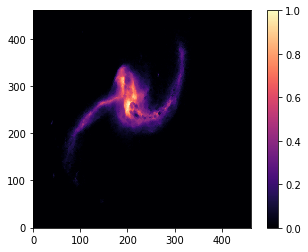

In [6]:
from skimage.transform import rescale
from skimage.morphology import erosion
merger = fits.getdata(os.path.join('data', 'NGC2623.fits'), header=False).astype(float)
merger = rescale(merger, 0.6, anti_aliasing=False)
merger[merger < 0] = 0

# clean small stellar clumps
merger = erosion(erosion(merger))

# we increase the contrast
#merger = np.log10(merger) + 1
#merger[merger < 0] = 0

# we normalize so that it is
merger /= merger.max()

plt.imshow(merger, origin='lower', cmap=plotter.cmap_flux)
plt.colorbar()
plt.show()

In [7]:
merger_witdh = 2.
merger_pix_scl = merger_witdh / len(merger)
kwargs_merger = {
    'grid_center': (-0.2, 0.), # in arcsec
    'grid_shape': (merger_witdh, merger_witdh),  # in arcsec
    'pixel_scale_factor': merger_pix_scl / pix_scl,  # in arcsec
}
pprint(kwargs_merger)
source_model_input = LightModel(['PIXELATED'], pixel_interpol='bicubic',
                                kwargs_pixelated=kwargs_merger)
amp_src = 3e-1
kwargs_source_input = [{'pixels': amp_src * merger}]

{'grid_center': (-0.2, 0.0),
 'grid_shape': (2.0, 2.0),
 'pixel_scale_factor': 0.05411255411255411}


### Generate the lens image

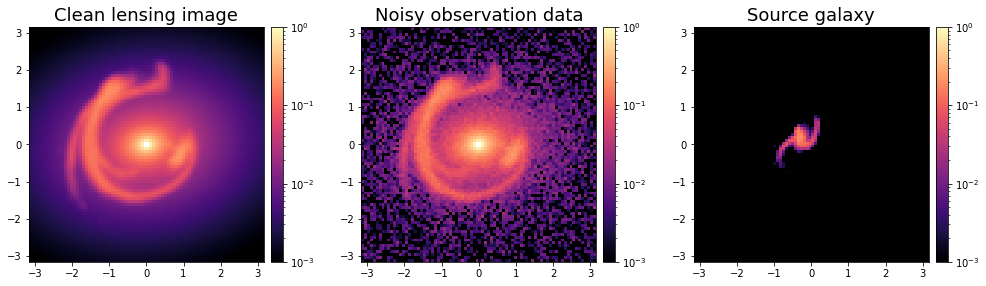

In [8]:
# Generate a lensed image based on source and lens models
kwargs_numerics_simu = {'supersampling_factor': 5}
lens_image_simu = LensImage(pixel_grid, psf, noise_class=noise,
                         lens_mass_model_class=lens_model_input,
                         source_model_class=source_model_input,
                         lens_light_model_class=lens_light_model_input,
                         kwargs_numerics=kwargs_numerics_simu)

kwargs_all_input = dict(kwargs_lens=kwargs_lens_input, 
                        kwargs_lens_light=kwargs_lens_light_input,
                        kwargs_source=kwargs_source_input)
image = lens_image_simu.model(**kwargs_all_input)

data = lens_image_simu.simulation(**kwargs_all_input, compute_true_noise_map=True, noise_seed=29)

source_input = lens_image_simu.source_surface_brightness(kwargs_source_input, de_lensed=True, unconvolved=True)
#extent_src = lens_image_simu.SourceModel.pixel_grid.extent

# visualize simulated products
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 4))
img1 = ax1.imshow(image, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
plot_util.nice_colorbar(img1)
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax2.set_title("Noisy observation data", fontsize=FS)
plot_util.nice_colorbar(img2)
img3 = ax3.imshow(source_input, origin='lower', extent=extent, norm=plotter.norm_flux, cmap=plotter.cmap_flux)
ax3.set_title("Source galaxy", fontsize=FS)
plot_util.nice_colorbar(img3)
fig.tight_layout()
plt.show()

In [9]:
# inform the plotter of the data
plotter.set_data(data)

## 2. Pixelated source reconstruction

### Create a model for fitting

In [10]:
# Setup the source model: pixelated on a regular grid
kwargs_pixelated_source = {
    'pixel_scale_factor': 2/3.,  # = data pixel size / source pixel size
    'grid_center': (-0.3, 0.1), 
    'grid_shape': (2.1, 2.1), # arcsec
}
source_model = LightModel(['PIXELATED'],
                          kwargs_pixelated=kwargs_pixelated_source)

kwargs_numerics_fit = {'supersampling_factor': 5}
lens_image = LensImage(deepcopy(pixel_grid), psf, noise_class=noise,
                       lens_mass_model_class=lens_model_input,
                       source_model_class=source_model,
                       lens_light_model_class=lens_light_model_input,
                       kwargs_numerics=kwargs_numerics_fit)

In [11]:
kwargs_init = {
    'kwargs_lens': [{}, {}],
    'kwargs_lens_light': [{}],
    'kwargs_source': [{'pixels': 1e-8}],
}
kwargs_fixed = {
    'kwargs_lens': kwargs_lens_input,
    'kwargs_lens_light': kwargs_lens_light_input,
    'kwargs_source': [{}],
}
parameters = Parameters(lens_image, kwargs_init, kwargs_fixed)
print("Number of fitted parameters:", parameters.num_parameters)
#print("Parameter names:", parameters.names)

Number of fitted parameters: 1521


In [12]:
# inform the plotter about the true source (on the pixelated grid)
x_grid_src, y_grid_src = lens_image.SourceModel.pixel_grid.pixel_coordinates
source_input_fitgrid = lens_image_simu.SourceModel.surface_brightness(x_grid_src, y_grid_src, kwargs_source_input)
source_input_fitgrid *= lens_image.Grid.pixel_area
plotter.set_ref_source(source_input_fitgrid)

### Loss function

For now, `Herculens` supports only a simple euclidean distance as the likelihood term (`'l2_norm'`), instead than the more usual $\chi^2$ (`'chi2'`). This will be fixed in a future version.

In [13]:
loss = Loss(data, lens_image, parameters, 
            likelihood_type='l2_norm',
            regularization_terms=[
                'l1_starlet_source', 
                'l1_battle_source',
                'positivity_source'
            ], 
            regularization_strengths=[
                (0, 3), 
                3, 
                3
            ]
           )

print("Loss at initial values:", loss(parameters.initial_values()))

Loss at initial values: 2.2460957


### Minimise the loss function using `optax`

We use the adaptive gradient descent algorithm AdaBelief to optimize the values of all source pixels.

In [14]:
optimizer = Optimizer(loss, parameters)

# optimizer settings
max_iterations = 800
init_learning_rate = 1e-4

best_fit, logL, extra_fields, runtime \
    = optimizer.optax(max_iterations=max_iterations, 
                      init_learning_rate=init_learning_rate,
                      restart_from_init=True)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss(best_fit))

# save results as kwargs
kwargs_final = parameters.best_fit_values(as_kwargs=True)

optax.adabelief: 100%|██████████| 800/800 [00:18<00:00, 42.57it/s]


Runtime: 18.799733877182007
Loss at best-fit: 0.1597487


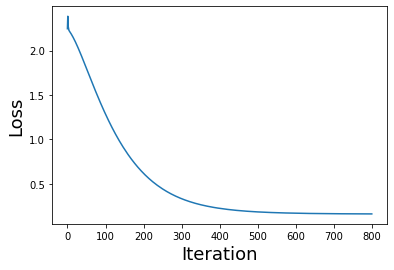

In [15]:
fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
plt.show()

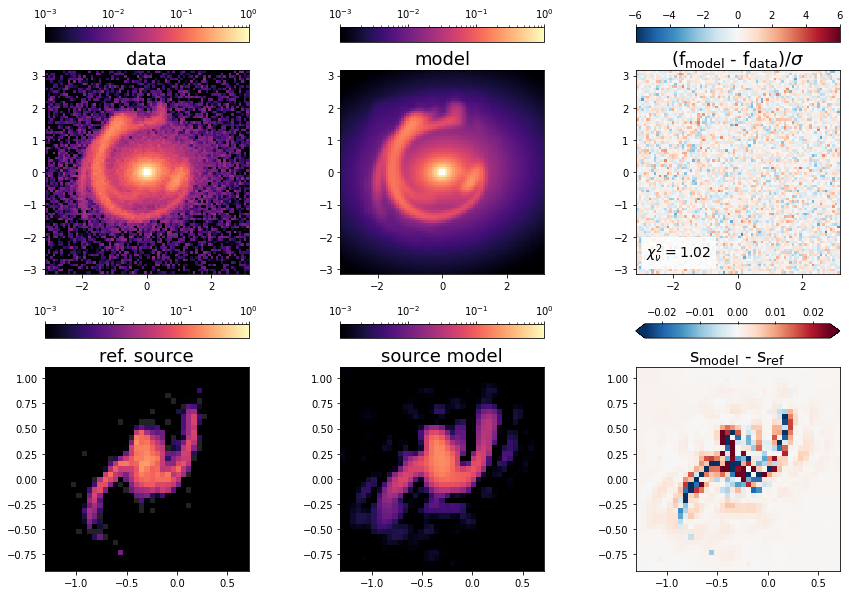

In [16]:
fig = plotter.model_summary(lens_image, kwargs_final)
plt.show()

## 3. What about an analytical+pixelated source model?

Below we try to model the source with a Sérsic profile with pixelated deviations, just like the other notebook is doing for the lens potential. This effectively means that the source has a smooth component (the Sérsic) and various wavelet scales associated, from small details to coarse scales.

This demonstrates the high flexibility of `Herculens`: you can superimpose analytical and pixelated components as you wish!

In [17]:
# Setup the source model: pixelated on a regular grid
cx0_src_fit, cy0_src_fit = -0.3, 0.1
kwargs_pixelated_source = {
    'pixel_scale_factor': 2/3.,  # = data pixel size / source pixel size
    'grid_center': (cx0_src_fit, cy0_src_fit), 
    'grid_shape': (2.1, 2.1), # arcsec
}
source_model = LightModel(['SERSIC_ELLIPSE', 'PIXELATED'],
                          kwargs_pixelated=kwargs_pixelated_source)

kwargs_numerics_fit = {'supersampling_factor': 5}
lens_image_hybrid = LensImage(deepcopy(pixel_grid), psf, noise_class=noise,
                       lens_mass_model_class=lens_model_input,
                       source_model_class=source_model,
                       lens_light_model_class=lens_light_model_input,
                       kwargs_numerics=kwargs_numerics_fit)

In [18]:
# inform the plotter about the true source (on the pixelated grid)
x_grid_src, y_grid_src = lens_image_hybrid.SourceModel.pixel_grid.pixel_coordinates
source_input_fitgrid = lens_image_simu.SourceModel.surface_brightness(x_grid_src, y_grid_src, kwargs_source_input)
source_input_fitgrid *= lens_image.Grid.pixel_area
plotter.set_ref_source(source_input_fitgrid)

In [19]:
kwargs_init = {
    'kwargs_lens': [{}, {}],
    'kwargs_lens_light': [{}],
    'kwargs_source': [
        {'amp': 3., 'R_sersic': 0.1, 'n_sersic': 1.5, 'e1': -0.2, 'e2': 0.001,
         'center_x': cx0_src_fit, 'center_y': cy0_src_fit}, 
        #{'pixels': deepcopy(kwargs_final['kwargs_source'][-1]['pixels'])}
        {'pixels': 1e-8}
    ],
}
kwargs_fixed = {
    'kwargs_lens': kwargs_lens_input,
    'kwargs_lens_light': kwargs_lens_light_input,
    'kwargs_source': [{}, {}],
}
parameters_hybrid = Parameters(lens_image_hybrid, kwargs_init, kwargs_fixed)
print("Number of fitted parameters:", parameters_hybrid.num_parameters)
#print("Parameter names:", parameters.names)

Number of fitted parameters: 1528


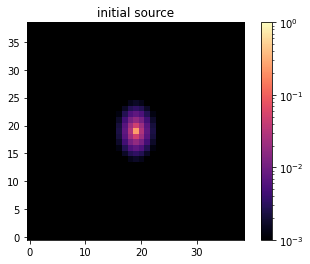

In [20]:
# visualize hybrid source
kwargs_src_hyb_init = parameters_hybrid.initial_values(as_kwargs=True)['kwargs_source']
source_hybrid_init = lens_image_hybrid.SourceModel.surface_brightness(x_grid_src, y_grid_src, 
                                                                      kwargs_src_hyb_init, 
                                                                      k=None)  # k=0 for Sérsic, k=1 for pixels
source_hybrid_init *= lens_image_hybrid.Grid.pixel_area

plt.title("initial source")
plt.imshow(source_hybrid_init, origin='lower', cmap=plotter.cmap_flux, norm=plotter.norm_flux)
plt.colorbar()
plt.show()

In [21]:
loss_hybrid = Loss(data, lens_image_hybrid, parameters_hybrid, 
            likelihood_type='l2_norm',
            regularization_terms=[
                'l1_starlet_source', 
                'l1_battle_source',
                'positivity_source'
            ], 
            regularization_strengths=[
                (0, 3), 
                3, 
                3
            ])

print("Loss at initial values:", loss_hybrid(parameters_hybrid.initial_values()))

Loss at initial values: 1.9314747


In [22]:
optimizer_hybrid = Optimizer(loss_hybrid, parameters_hybrid)

# optimizer settings
max_iterations = 800
init_learning_rate = 1e-4

best_fit, logL, extra_fields, runtime \
    = optimizer_hybrid.optax(max_iterations=max_iterations, 
                      init_learning_rate=init_learning_rate,
                      restart_from_init=True)
print(f"Runtime: {runtime}")
print("Loss at best-fit:", loss_hybrid(best_fit))

# save results as kwargs
kwargs_final_hybrid = parameters_hybrid.best_fit_values(as_kwargs=True)

optax.adabelief: 100%|██████████| 800/800 [00:24<00:00, 33.25it/s]


Runtime: 24.059720039367676
Loss at best-fit: 0.1586169


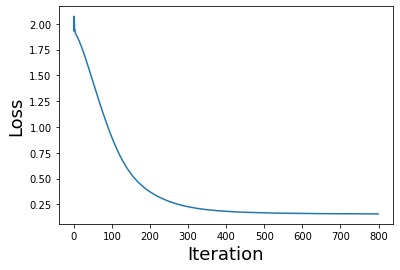

In [23]:
fig, ax = plt.subplots(1, 1)
ax.plot(range(len(extra_fields['loss_history'])), extra_fields['loss_history'])
ax.set_ylabel("Loss", fontsize=18)
ax.set_xlabel("Iteration", fontsize=18)
plt.show()

_Note: in the plot below, **only the pixelated component** of the source model is shown! Hence the hole in the middle ;)_

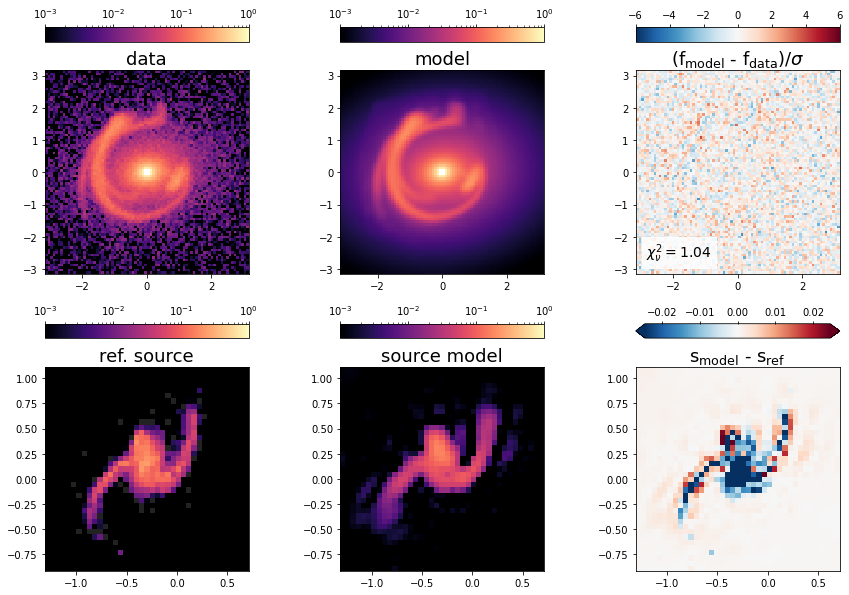

In [24]:
fig = plotter.model_summary(lens_image_hybrid, kwargs_final_hybrid)
plt.show()

#### Let's explore the spatial scales of the source model

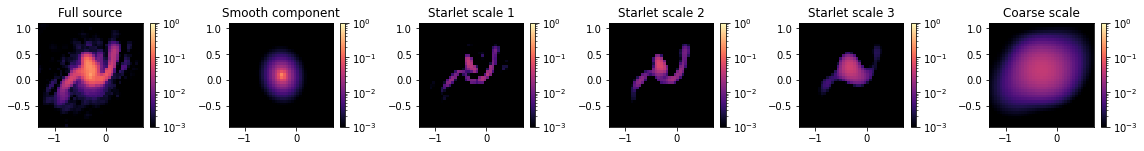

In [25]:
from herculens.Util.jax_util import WaveletTransform
# dissect the various components of the source
def get_source_component(component='pixelated', starlet_scale=None):
    kwargs_src = parameters_hybrid.best_fit_values(as_kwargs=True)['kwargs_source']
    if component == 'smooth':
        k = 0  # 'SERSIC_ELLIPSE'
    elif component == 'pixelated':
        k = 1  # 'PIXELATED'
    else:
        k = None  # all profiles
    source_comp = np.array(lens_image_hybrid.SourceModel.surface_brightness(x_grid_src, y_grid_src, kwargs_src, k=k))
    source_comp *= lens_image_hybrid.Grid.pixel_area
    if isinstance(starlet_scale, int):
        max_scales = int(np.log(len(source_comp)))
        starlet = WaveletTransform(max_scales, wavelet_type='starlet')
        source_comp = np.array(starlet.decompose(source_comp)[starlet_scale])
    source_extent = lens_image_hybrid.SourceModel.pixel_grid.extent
    return source_comp, source_extent

num_pixel_scales = 4
fig, axes = plt.subplots(1, num_pixel_scales+2, figsize=(16, 3))
ax = axes[0]
ax.set_title("Full source")
src_comp, src_extent = get_source_component(component=None)
im = ax.imshow(src_comp, origin='lower', extent=src_extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
plot_util.nice_colorbar(im)
ax = axes[1]
ax.set_title("Smooth component")
src_comp, src_extent = get_source_component(component='smooth')
im = ax.imshow(src_comp, origin='lower', extent=src_extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
plot_util.nice_colorbar(im)
for j in range(0, num_pixel_scales):
    ax = axes[j+2]
    if j < num_pixel_scales-1:
        ax.set_title(f"Starlet scale {j+1}")
    else:
        ax.set_title("Coarse scale")
    src_comp, src_extent = get_source_component(component='pixelated', starlet_scale=j)
    im = ax.imshow(src_comp, origin='lower', extent=src_extent, cmap=plotter.cmap_flux, norm=plotter.norm_flux)
    plot_util.nice_colorbar(im)
fig.tight_layout()
plt.show()

In [26]:
pprint(kwargs_final_hybrid['kwargs_source'])

[{'R_sersic': DeviceArray(0.18820873, dtype=float32),
  'amp': DeviceArray(3.1476676, dtype=float32),
  'center_x': DeviceArray(-0.28924066, dtype=float32),
  'center_y': DeviceArray(0.0827807, dtype=float32),
  'e1': DeviceArray(-0.08865828, dtype=float32),
  'e2': DeviceArray(-0.02803525, dtype=float32),
  'n_sersic': DeviceArray(1.5934175, dtype=float32)},
 {'pixels': DeviceArray([[0.00038619, 0.00033589, 0.00023662, ..., 0.00023968,
              0.00023711, 0.00023391],
             [0.00042654, 0.00030928, 0.00020738, ..., 0.00025977,
              0.00023185, 0.0002127 ],
             [0.00042047, 0.0003381 , 0.00031619, ..., 0.00027194,
              0.00021977, 0.00019932],
             ...,
             [0.00105686, 0.00106924, 0.00108515, ..., 0.00056415,
              0.00055786, 0.00054606],
             [0.00111587, 0.00117125, 0.00116096, ..., 0.00054975,
              0.00053513, 0.0005045 ],
             [0.00112895, 0.00119666, 0.00122279, ..., 0.00047423,
           